In [ ]:
pip install --upgrade scikit-learn

In [ ]:
pip install --upgrade imbalanced-learn

In [ ]:
inv_class_mapping

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

# ================================
# Load and preprocess dataset
# ================================
def load_dataset(directory, target_size=(224, 224), batch_size=32):
    datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_directory(
        directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    images = []
    labels = []

    for i in range(len(generator)):
        batch_imgs, batch_labels = generator.next()
        images.append(batch_imgs)
        labels.append(batch_labels)

    images = np.vstack(images)
    labels = np.vstack(labels)

    class_mapping = generator.class_indices
    inv_class_mapping = {v: k for k, v in class_mapping.items()}

    return images, labels, inv_class_mapping

# Load training dataset
train_images, train_labels, inv_class_mapping = load_dataset(
    "/kaggle/input/detail/Maize-Pest-Detection-And-Identification-master/DataSet on Maize Pests/Pest Detection/train",
    batch_size=32
)

# Load test dataset
test_images, test_labels, _ = load_dataset(
    "/kaggle/input/detail/Maize-Pest-Detection-And-Identification-master/DataSet on Maize Pests/Pest Detection/test",
    batch_size=32
)

print("Train set shape:", train_images.shape, train_labels.shape)
print("Test set shape:", test_images.shape, test_labels.shape)

# ================================
# Build Model
# ================================
def create_model(num_classes):
    base_model = keras.applications.MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    inputs = keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)

model = create_model(num_classes=len(inv_class_mapping))

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ================================
# Train model
# ================================
history = model.fit(
    train_images, train_labels,
    epochs=50,
    validation_data=(test_images, test_labels),
    batch_size=32
)

# ================================
# Save the model
# ================================
model.save('maize_mobilenet.keras')


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 52)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import cv2
import os
from PIL import ImageFile

# Handle truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# ================================
# Improved dataset loader with error handling
# ================================
def load_dataset(directory, target_size=(224, 224)):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))
    class_mapping = {class_name: idx for idx, class_name in enumerate(class_names)}
    
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        if not os.path.isdir(class_dir):
            continue
            
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                try:
                    img_path = os.path.join(class_dir, filename)
                    img = cv2.imread(img_path)
                    if img is None:
                        print(f"Skipping corrupted image: {img_path}")
                        continue
                        
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, target_size)
                    img = img.astype('float32') / 255.0
                    
                    images.append(img)
                    labels.append(class_mapping[class_name])
                except Exception as e:
                    print(f"Error loading {img_path}: {str(e)}")
                    continue
    
    images = np.array(images)
    labels = np.array(labels)
    labels = keras.utils.to_categorical(labels, num_classes=len(class_mapping))
    
    return images, labels, {v: k for k, v in class_mapping.items()}

# Load training dataset
print("Loading training data...")
train_images, train_labels, inv_class_mapping = load_dataset(
    "/kaggle/input/detail/Maize-Pest-Detection-And-Identification-master/DataSet on Maize Pests/Pest Detection/train"
)

# Load test dataset
print("Loading test data...")
test_images, test_labels, _ = load_dataset(
    "/kaggle/input/detail/Maize-Pest-Detection-And-Identification-master/DataSet on Maize Pests/Pest Detection/val"
)

# Convert to class indices for SMOTE
train_class_indices = np.argmax(train_labels, axis=1)
test_class_indices = np.argmax(test_labels, axis=1)

# Flatten training images for SMOTE
n_samples, height, width, channels = train_images.shape
train_images_flat = train_images.reshape(n_samples, height * width * channels)

# Apply SMOTE
# print("\nClass distribution before SMOTE:", np.bincount(train_class_indices))
smote = SMOTE(random_state=42)
train_images_balanced_flat, train_labels_balanced = smote.fit_resample(train_images_flat, train_class_indices)
train_images_balanced = train_images_balanced_flat.reshape(-1, height, width, channels)

# One-hot encode labels
y_train = keras.utils.to_categorical(train_labels_balanced, num_classes=len(inv_class_mapping))
y_test = keras.utils.to_categorical(test_class_indices, num_classes=len(inv_class_mapping))

# print("Class distribution after SMOTE:", np.bincount(np.argmax(y_train, axis=1)))

# ================================
# Build Model
# ================================
def create_model():
    base_model = keras.applications.MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    inputs = keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(inv_class_mapping), activation='softmax')(x)

    return keras.Model(inputs, outputs)

model = create_model()

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ================================
# Train model
# ================================
print("\nTraining model...")
history = model.fit(
    train_images_balanced, y_train,
    epochs=50,
    validation_data=(test_images, y_test),
    batch_size=16,
    verbose=1
)

# ================================
# Save the model
# ================================
model.save('maize_mobilenet.keras')
print("\nModel saved successfully!")

In [ ]:
import tensorflow as tf
print(tf.__version__)


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

# ================================
# Load and preprocess dataset
# ================================
def load_dataset(directory, target_size=(224, 224), batch_size=32):
    datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_directory(
        directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    images = []
    labels = []

    for i in range(len(generator)):
        batch_imgs, batch_labels = generator.next()
        images.append(batch_imgs)
        labels.append(batch_labels)

    images = np.vstack(images)
    labels = np.vstack(labels)

    class_mapping = generator.class_indices
    inv_class_mapping = {v: k for k, v in class_mapping.items()}

    return images, labels, inv_class_mapping

# Load training dataset
train_images, train_labels, inv_class_mapping = load_dataset(
    "/kaggle/input/detail/Maize-Pest-Detection-And-Identification-master/DataSet on Maize Pests/Pest Detection/train",
    batch_size=32
)

# Load test dataset
test_images, test_labels, _ = load_dataset(
    "/kaggle/input/detail/Maize-Pest-Detection-And-Identification-master/DataSet on Maize Pests/Pest Detection/test",
    batch_size=32
)

print("Train set shape:", train_images.shape, train_labels.shape)
print("Test set shape:", test_images.shape, test_labels.shape)

# ================================
# Build Model
# ================================
def create_model(num_classes):
    base_model = keras.applications.MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    inputs = keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)

model = create_model(num_classes=len(inv_class_mapping))

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ================================
# Train model
# ================================
history = model.fit(
    train_images, train_labels,
    epochs=50,
    validation_data=(test_images, test_labels),
    batch_size=32
)

# ================================
# Save the model
# ================================
model.save('maize_mobilenet.keras')


2025-07-20 05:56:09.534925: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752990969.728432     159 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752990969.784480     159 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 6514 images belonging to 14 classes.


AttributeError: 'DirectoryIterator' object has no attribute 'next'

Found 12795 images belonging to 6 classes.
Found 4832 images belonging to 6 classes.
Train set: (12795, 224, 224, 3) (12795, 6)
Test set: (4832, 224, 224, 3) (4832, 6)
Label mapping: {0: 'Healthy (No Deficiency)', 1: 'All Nutrients Deficient', 2: 'Potassium Deficiency', 3: 'Nitrogen Deficiency', 4: 'Phosphorus Deficiency', 5: 'Zinc Deficiency'}


I0000 00:00:1752991197.252062     159 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/50


I0000 00:00:1752991224.989507     230 service.cc:148] XLA service 0x7edd3c1122b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752991224.990225     230 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1752991225.855458     230 cuda_dnn.cc:529] Loaded cuDNN version 90300


  6/400 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.2381 - loss: 2.2131  

I0000 00:00:1752991229.736086     230 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


400/400 ━━━━━━━━━━━━━━━━━━━━ 39s 68ms/step - accuracy: 0.6716 - loss: 0.9522 - val_accuracy: 0.8963 - val_loss: 0.3450
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.8746 - loss: 0.3681 - val_accuracy: 0.9303 - val_loss: 0.2274
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.9123 - loss: 0.2617 - val_accuracy: 0.9563 - val_loss: 0.1625
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.9299 - loss: 0.2058 - val_accuracy: 0.9714 - val_loss: 0.0985
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.9412 - loss: 0.1679 - val_accuracy: 0.9632 - val_loss: 0.1038
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.9511 - loss: 0.1389 - val_accuracy: 0.9719 - val_loss: 0.0930
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.9543 - loss: 0.1296 - val_accuracy: 0.9789 - val_loss: 0.0615
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.9614 - loss: 0.1097 - val_accurac

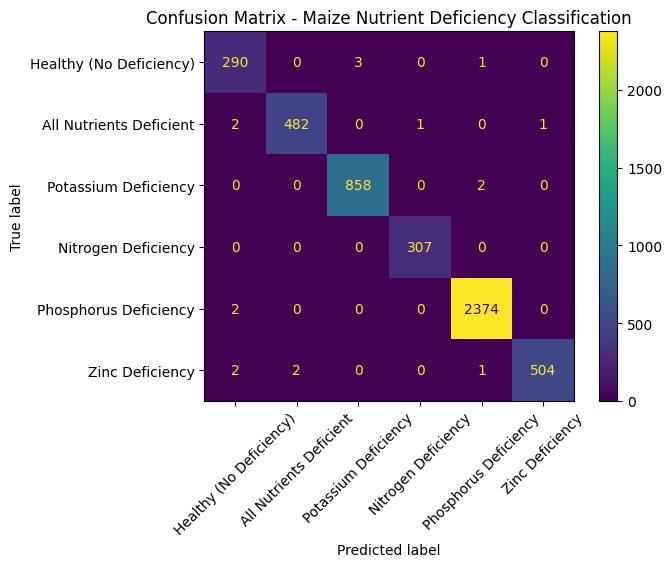

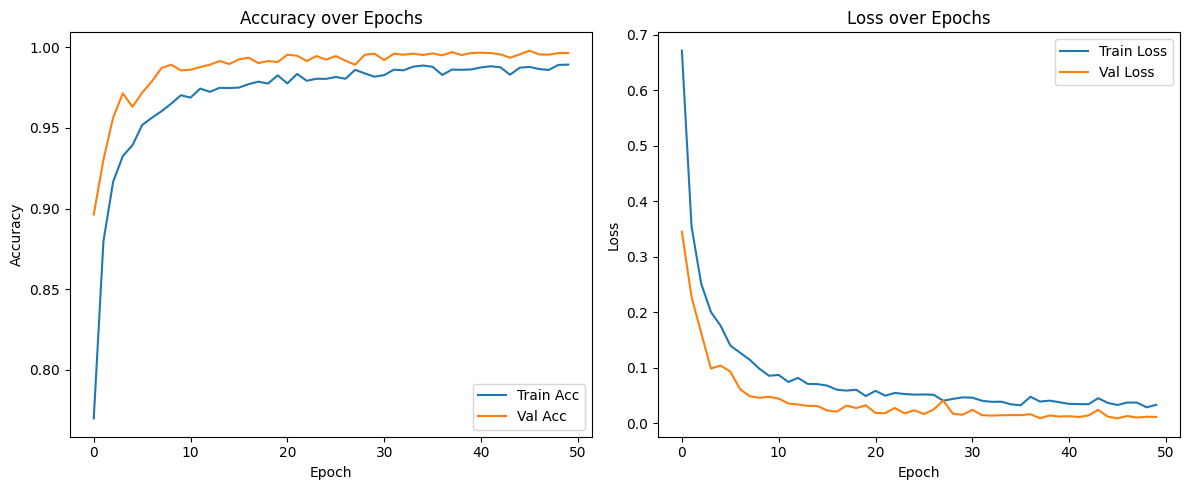

Model saved as 'maize_nutrient_deficiency_mobilenet.keras'


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os

# ================================
# Readable nutrient deficiency labels
# ================================
readable_labels = {
    "ALL Present": "Healthy (No Deficiency)",
    "ALLAB": "All Nutrients Deficient",
    "KAB": "Potassium Deficiency",
    "NAB": "Nitrogen Deficiency",
    "PAB": "Phosphorus Deficiency",
    "ZNAB": "Zinc Deficiency"
}

# ================================
# Load and preprocess dataset
# ================================
def load_dataset(directory, target_size=(224, 224), batch_size=32):
    datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_directory(
        directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    images = []
    labels = []

    for _ in range(len(generator)):
        batch_imgs, batch_labels = next(generator)
        images.append(batch_imgs)
        labels.append(batch_labels)

    images = np.vstack(images)
    labels = np.vstack(labels)

    class_mapping = generator.class_indices
    inv_class_mapping = {v: k for k, v in class_mapping.items()}

    # Map indices to readable labels
    inv_class_mapping_readable = {idx: readable_labels[orig_label] for idx, orig_label in inv_class_mapping.items()}

    return images, labels, inv_class_mapping, inv_class_mapping_readable

# ================================
# Load datasets
# ================================
train_images, train_labels, inv_class_mapping, inv_class_mapping_readable = load_dataset(
    "/kaggle/input/maize-plant-leaf-nutrient-deficiency-dataset/Nutrition_dataset/train",
    batch_size=32
)

test_images, test_labels, _, _ = load_dataset(
    "/kaggle/input/maize-plant-leaf-nutrient-deficiency-dataset/Nutrition_dataset/test",
    batch_size=32
)

print("Train set:", train_images.shape, train_labels.shape)
print("Test set:", test_images.shape, test_labels.shape)
print("Label mapping:", inv_class_mapping_readable)

# ================================
# Build Model
# ================================
def create_model(num_classes):
    base_model = keras.applications.MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    inputs = keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    return model

model = create_model(num_classes=len(inv_class_mapping))

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ================================
# Train Model
# ================================
history = model.fit(
    train_images, train_labels,
    validation_data=(test_images, test_labels),
    epochs=50,
    batch_size=32
)

# ================================
# Evaluate and plot confusion matrix
# ================================
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=list(inv_class_mapping_readable.values())
)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix - Maize Nutrient Deficiency Classification")
plt.show()

# ================================
# Plot training curves
# ================================
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# ================================
# Save the model
# ================================
model.save('maize_nutrient_deficiency_mobilenet.keras')
print("Model saved as 'maize_nutrient_deficiency_mobilenet.keras'")
